In [1]:
library(gdata)
library(ggplot2)
library(grid)
library(gridExtra)

gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.

gdata: read.xls support for 'XLSX' (Excel 2007+) files ENABLED.

Attaching package: ‘gdata’

The following object is masked from ‘package:stats’:

    nobs

The following object is masked from ‘package:utils’:

    object.size

The following object is masked from ‘package:base’:

    startsWith


Attaching package: ‘gridExtra’

The following object is masked from ‘package:gdata’:

    combine



In [2]:
DT <- read.table("../Data/All_data.txt")

In [3]:
ratio_align <- read.table("../Data/Alignment_ratios_within_diseases_across_all_NHI_patients_metrs_burdens.txt")

In [4]:
metr_burden <- "daly"
metr_res <- "RCTs"

In [5]:
levels(DT$Disease)

[1] "All"                                                                                     
 [2] "Cardiovascular and circulatory diseases"                                                 
 [3] "Chronic respiratory diseases"                                                            
 [4] "Cirrhosis of the liver"                                                                  
 [5] "Congenital anomalies"                                                                    
 [6] "Diabetes, urinary diseases and male infertility"                                         
 [7] "Diarrhea, lower respiratory infections, meningitis, and other common infectious diseases"
 [8] "Digestive diseases (except cirrhosis)"                                                   
 [9] "Gynecological diseases"                                                                  
[10] "Hemoglobinopathies and hemolytic anemias"                                                
[11] "Hepatitis"                                                                               
[12] "HIV/AIDS"                                                                                
[13] "Leprosy"                                                                                 
[14] "Malaria"                                                                                 
[15] "Maternal disorders"                                                                      
[16] "Mental and behavioral disorders"                                                         
[17] "Musculoskeletal disorders"                                                               
[18] "Neglected tropical diseases excluding malaria"                                           
[19] "Neonatal disorders"                                                                      
[20] "Neoplasms"                                                                               
[21] "Neurological disorders"                                                                  
[22] "Nutritional deficiencies"                                                                
[23] "Oral disorders"                                                                          
[24] "Sense organ diseases"                                                                    
[25] "Sexually transmitted diseases excluding HIV"                                             
[26] "Skin and subcutaneous diseases"                                                          
[27] "Sudden infant death syndrome"                                                            
[28] "Tuberculosis"

In [6]:
#Disease labels for plot
DT$Dis_lab <- DT$Disease
levels(DT$Dis_lab) <- c("All diseases",
               "Cardiovascular and circulatory diseases",
               "Chronic respiratory diseases",
               "Cirrhosis of the liver",
               "Congenital anomalies",
               "Diabetes, urinary diseases, male infertility",
               "Common infectious diseases",
               "Digestive diseases",
               "Gynecological diseases",
               "Hemoglob. and\nhemolytic anemia",
               "Hepatitis",
               "HIV/AIDS",
               "Leprosy",
               "Malaria",
               "Maternal disorders",
               "Mental and behavioral disorders",
               "Musculoskeletal disorders",
               "Neglected tropical diseases",
               "Neonatal disorders",
               "Neoplasms",
               "Neurological disorders",
               "Nutritional deficiencies",
               "Oral disorders",
               "Sense organ diseases",
               "Sexually transmitted diseases",
               "Skin and subcutaneous diseases",
               "Sudden infant death syndrome",
               "Tuberculosis")

In [7]:
regs <- levels(DT$Region)
#Non-High-income burden
gbd_t_r <- DT[DT$Disease=="All" & !DT$Region%in%c("All","Non-HI","High-income"),
              c(1,intersect(grep("^burden",names(DT)),grep(metr_burden,names(DT))))]

In [8]:
gbd_t_r

,Region,burden_daly
29,"Central Europe, Eastern Europe, and Central Asia",151517873.106757
85,Latin America and Caribbean,115507386.951616
141,North Africa and Middle East,102273396.008358
169,South Asia,610711947.47999
197,"Southeast Asia, East Asia and Oceania",460946821.574246
225,Sub-Saharian Africa,547554824.228482


In [9]:
regs <- c("High-income", as.character(gbd_t_r$Region)[order(gbd_t_r$burden)])
regs

[1] "High-income"                                     
[2] "North Africa and Middle East"                    
[3] "Latin America and Caribbean"                     
[4] "Central Europe, Eastern Europe, and Central Asia"
[5] "Southeast Asia, East Asia and Oceania"           
[6] "Sub-Saharian Africa"                             
[7] "South Asia"

In [10]:
regs_lab <- c("High-income",
             "North Africa\nMiddle East",
             "Latin America",
             "Eastern Europe\nCentral Asia",
             "Southeast Asia\nOceania",
             "Sub-Saharian\nAfrica",
             "South Asia")

In [11]:
#10 diseases with highest burden
bglob_dis <- DT[DT$Region=="All" & DT$Disease!="All", 
                c(2,intersect(grep("^burden",names(DT)),grep(metr_burden,names(DT)))),]
bglob_dis <- bglob_dis[order(bglob_dis$burden,decreasing = TRUE),]
dis <- c("All",as.character(bglob_dis$Disease)[1:10])

In [12]:
dis

[1] "All"                                                                                     
 [2] "Diarrhea, lower respiratory infections, meningitis, and other common infectious diseases"
 [3] "Cardiovascular and circulatory diseases"                                                 
 [4] "Neonatal disorders"                                                                      
 [5] "Neoplasms"                                                                               
 [6] "Mental and behavioral disorders"                                                         
 [7] "Musculoskeletal disorders"                                                               
 [8] "Chronic respiratory diseases"                                                            
 [9] "Malaria"                                                                                 
[10] "HIV/AIDS"                                                                                
[11] "Nutritional deficiencies"

In [13]:
#For annotating with ratio of alignment
form <- function(x){
paste(format(round(x[2],1),nsmall = 1),
           " [",format(round(x[1],1),nsmall = 1),
           "-",format(round(x[3],1),nsmall = 1),"]")
    }

In [14]:
max_plot <- 100

In [15]:
L <- list()
for(i in 1:length(dis)){
    d <- dis[i]
    dlab <- unique(as.character(DT$Dis_lab[DT$Disease==d]))

    dtp <- DT[DT$Disease==d & !DT$Region%in%c("All","Non-HI"),c(which(names(DT)%in%c("Region")),
                        intersect(grep(metr_burden,names(DT)),grep("Prop_glob_burden",names(DT))),
                        intersect(grep(metr_res,names(DT)),grep("Prop_glob_",names(DT)))),]
    
    dfb <- dtp[,c(1,2)]
    names(dfb) <- c("Region","prop")
    dfb$mes <- "burden"
    dfr <- dtp[,c(1,4)]
    names(dfr) <- c("Region","prop")
    dfr$mes <- "research"
    dt <- rbind(dfb,dfr)

    dfre <- dtp[,c(1,3,5)]
    names(dfre) <- c("Region","prop_low","prop_up")
    dfre$mes <- "research"
    
    #Order of regions:
    dt$Region <- reorder(dt$Region,new.order=regs)
    dfre$Region <- reorder(dfre$Region,new.order=as.character(regs))
    dt$Reg_lab <- dt$Region
    levels(dt$Reg_lab) <- regs_lab

    dlbl <- dt[order(dt$Region),]
    dlbl <- dlbl[!duplicated(dlbl$Region),]

    #Highlighting GAPS
    dt$gap <- dt$Region
    levels(dt$gap) <- unlist(lapply(levels(dt$Region),
                                    function(x){
                                        ifelse(sum(dfre$Region==x)==0,NA,
                                        dt$prop[dt$mes=="burden" & dt$Region==x]/
                                        dfre$prop_up[dfre$Region==x])}))
    dt$gap_col <- dt$mes
    dt$gap_col[as.numeric(as.character(dt$gap))>=2 & dt$gap_col=="burden"] <- "burden_gap"
    
    dlbl <- dt[order(dt$Region),]
    dlbl <- dlbl[dlbl$mes=="burden",]
    dlbl$gap_text <- "plain"
    dlbl$gap_text[dlbl$gap_col=="burden_gap"] <- "bold"

    
    #GGPLOT Object
    p <- ggplot(dt,aes(Region))
#    p <- p + geom_bar(aes(fill=mes,y=prop),position="dodge",stat="identity",width=0.8)
    p <- p + geom_bar(aes(fill=gap_col,y=prop),position="dodge",stat="identity",width=0.8)
    p <- p + geom_segment(aes(x=as.numeric(Region)-0.4,xend=as.numeric(Region)+0.4,y=prop/2,yend=prop/2,size=5),linetype="dashed",data=dt[dt$mes=="burden",],lwd=0.1)
    p <- p + geom_errorbar(aes(x=as.numeric(Region)+0.2,ymax=prop_up,ymin=prop_low),width=0.2,data=dfre)
#    p <- p + scale_fill_manual(values = c("burden"="orange","research"="blue"))
   p <- p + scale_fill_manual(values = c("burden"="orange","burden_gap"="red","research"="blue"))

    p <- p + scale_x_discrete(label = dlbl$Reg_lab
                             )


    if((i)%%3==1){
    p <- p + scale_y_continuous(limits = c(0,max_plot),breaks=seq(0,max_plot,10),
                                 name=paste("Global share across regions\nof",
                                           toupper(metr_burden),
                                           "and number of", metr_res, "(%)"))
    }
    else {p <- p + scale_y_continuous(limits = c(0,max_plot),breaks=seq(0,max_plot,10),
                                name=paste("\n")
                                )
        }

    p <- p + ggtitle(dlab)
    p <- p + theme( axis.text.x = element_text(
                    face=dlbl$gap_text,
                    angle=55,
                    hjust=1,
                    vjust=1.1,size=8)) +
             theme(panel.background = element_blank()) + 
             theme(panel.grid.major.y = element_line(colour = "grey",size=0.1)) +
             theme(panel.grid.major.x = element_blank()) + 
             theme(axis.ticks.x=element_blank()) + 
             theme(legend.position = "none") + 
             theme(axis.title.x=element_blank())

    p <- p + annotate("text",x=(length(regs)+1)/2,y=max_plot-5,label=
                paste("R =",
                 form(ratio_align[ratio_align$Disease==as.character(dis[i]),
                   intersect(grep("all",names(ratio_align)),
                             intersect(grep("nogap",names(ratio_align)),
                                            intersect(grep(metr_res,names(ratio_align)),
                                               grep(metr_burden,names(ratio_align)))))]) )
                )
    L[[i]] <- p

}

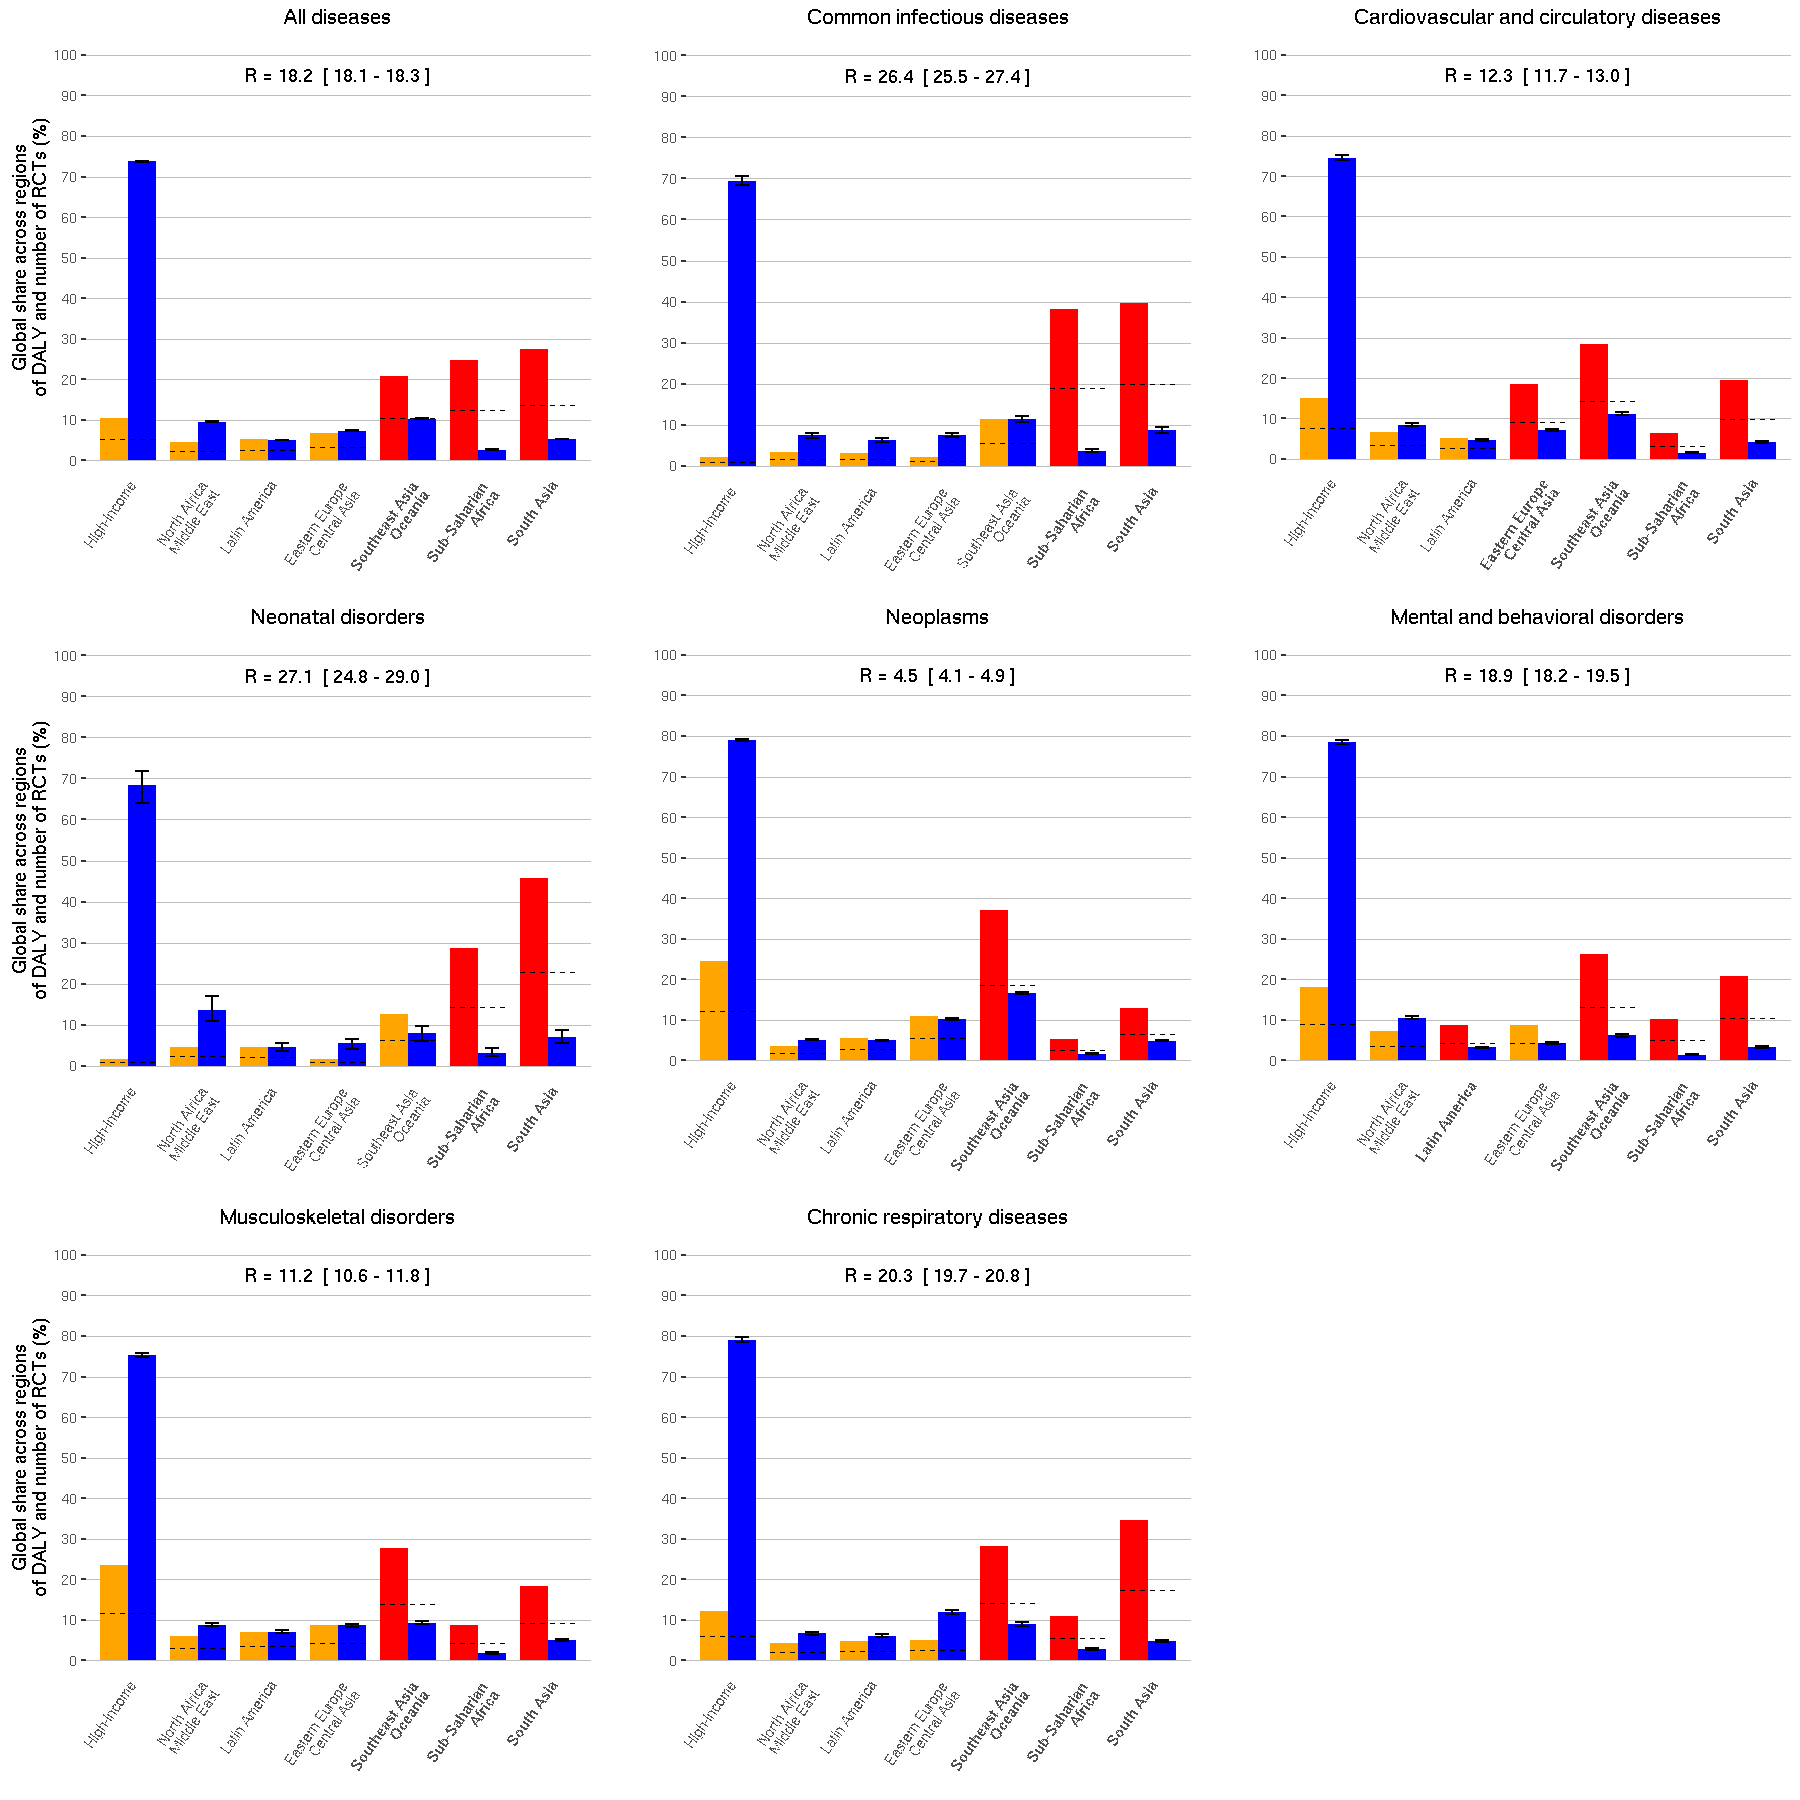

In [16]:
options(repr.plot.width=15, repr.plot.height=15)

grid.arrange(L[[1]],L[[2]],L[[3]],L[[4]],L[[5]],L[[6]],L[[7]],L[[8]] , ncol=3)

In [17]:
ggsave(filename = "../Figures/RCTs_vs_DALYs_withindis.pdf",
       plot=grid.arrange(L[[1]],L[[2]],L[[3]],L[[4]],L[[5]],L[[6]],L[[7]],L[[8]], ncol=3),
       width=15,height=15)

# Share research vs burden across Non-high-income regions

In [18]:
regs <- as.character(gbd_t_r$Region)[order(gbd_t_r$burden)]
regs

[1] "North Africa and Middle East"                    
[2] "Latin America and Caribbean"                     
[3] "Central Europe, Eastern Europe, and Central Asia"
[4] "Southeast Asia, East Asia and Oceania"           
[5] "Sub-Saharian Africa"                             
[6] "South Asia"

In [19]:
regs_lab <- c("North Africa\nMiddle East",
             "Latin America",
             "Eastern Europe\nCentral Asia",
             "Southeast Asia\nOceania",
             "Sub-Saharian\nAfrica",
             "South Asia")

In [20]:
#10 diseases with highest burden
bnhi_dis <- DT[DT$Region=="Non-HI" & DT$Disease!="All", 
                c(2,intersect(grep("^burden",names(DT)),grep(metr_burden,names(DT)))),]
bnhi_dis <- bnhi_dis[order(bnhi_dis$burden,decreasing = TRUE),]
dis <- c("All",as.character(bnhi_dis$Disease)[1:10])

In [21]:
dis

[1] "All"                                                                                     
 [2] "Diarrhea, lower respiratory infections, meningitis, and other common infectious diseases"
 [3] "Cardiovascular and circulatory diseases"                                                 
 [4] "Neonatal disorders"                                                                      
 [5] "Mental and behavioral disorders"                                                         
 [6] "Neoplasms"                                                                               
 [7] "Musculoskeletal disorders"                                                               
 [8] "Malaria"                                                                                 
 [9] "Chronic respiratory diseases"                                                            
[10] "HIV/AIDS"                                                                                
[11] "Nutritional deficiencies"

In [22]:
max_plot <- 100

In [23]:
L <- list()
for(i in 1:length(dis)){

    d <- dis[i]
    dlab <- unique(as.character(DT$Dis_lab[DT$Disease==d]))

    dtp <- DT[DT$Disease==d & !DT$Region%in%c("All","Non-HI","High-income"),c(which(names(DT)%in%c("Region")),
                        intersect(grep(metr_burden,names(DT)),grep("Prop_NHI_burden",names(DT))),
                        intersect(grep(metr_res,names(DT)),grep("Prop_NHI_",names(DT)))),]
    
    dfb <- dtp[,c(1,2)]
    names(dfb) <- c("Region","prop")
    dfb$mes <- "burden"
    dfr <- dtp[,c(1,4)]
    names(dfr) <- c("Region","prop")
    dfr$mes <- "research"
    dt <- rbind(dfb,dfr)

    dfre <- dtp[,c(1,3,5)]
    names(dfre) <- c("Region","prop_low","prop_up")
    dfre$mes <- "research"
    
    #Order of regions:
    dt$Region <- reorder(dt$Region,new.order=regs)
    dfre$Region <- reorder(dfre$Region,new.order=as.character(regs))
    dt$Reg_lab <- dt$Region
    levels(dt$Reg_lab) <- regs_lab

    dlbl <- dt[order(dt$Region),]
    dlbl <- dlbl[!duplicated(dlbl$Region),]

    #Highlighting GAPS
    dt$gap <- dt$Region
    levels(dt$gap) <- unlist(lapply(levels(dt$Region),
                                    function(x){
                                        ifelse(sum(dfre$Region==x)==0,NA,
                                        dt$prop[dt$mes=="burden" & dt$Region==x]/
                                        dfre$prop_up[dfre$Region==x])}))
    dt$gap_col <- dt$mes
    dt$gap_col[as.numeric(as.character(dt$gap))>=2 & dt$gap_col=="burden"] <- "burden_gap"
    
    dlbl <- dt[order(dt$Region),]
    dlbl <- dlbl[dlbl$mes=="burden",]
    dlbl$gap_text <- "plain"
    dlbl$gap_text[dlbl$gap_col=="burden_gap"] <- "bold"

    
    #GGPLOT Object
    p <- ggplot(dt,aes(Region))
    p <- p + geom_bar(aes(fill=gap_col,y=prop),position="dodge",stat="identity",width=0.8)
    p <- p + geom_segment(aes(x=as.numeric(Region)-0.4,xend=as.numeric(Region)+0.4,y=prop/2,yend=prop/2,size=5),linetype="dashed",data=dt[dt$mes=="burden",],lwd=0.1)
    p <- p + geom_errorbar(aes(x=as.numeric(Region)+0.2,ymax=prop_up,ymin=prop_low),width=0.2,data=dfre)
    p <- p + scale_fill_manual(values = c("burden"="orange","burden_gap"="red","research"="blue"))

    p <- p + scale_x_discrete(label = dlbl$Reg_lab)

    if(i%%3==1){
    p <- p + scale_y_continuous(limits = c(0,max_plot),breaks=seq(0,max_plot,10),
                                name=paste("Share across non-high-income regions\nof",
                                           toupper(metr_burden),
                                           "and number of", metr_res, "(%)"))
    }
    else {p <- p + scale_y_continuous(limits = c(0,max_plot),breaks=seq(0,max_plot,10),
                                name=paste("\n")
                                )
        }

    p <- p + ggtitle(dlab)
    p <- p + theme( axis.text.x = element_text(
                    face=dlbl$gap_text,
                    angle=55,
                    hjust=1,
                    vjust=1.1,size=8)) +
             theme(panel.background = element_blank()) + 
             theme(panel.grid.major.y = element_line(colour = "grey",size=0.1)) +
             theme(panel.grid.major.x = element_blank()) + 
             theme(axis.ticks.x=element_blank()) + 
             theme(legend.position = "none") + 
             theme(axis.title.x=element_blank())

    p <- p + annotate("text",x=(length(regs)+1)/2,y=max_plot-5,label=
                paste("R =",
                 form(ratio_align[ratio_align$Disease==as.character(dis[i]),
                   intersect(grep("NHI",names(ratio_align)),
                             intersect(grep("nogap",names(ratio_align)),
                                            intersect(grep(metr_res,names(ratio_align)),
                                               grep(metr_burden,names(ratio_align)))))]) )
                )
    
    L[[i]] <- p

}


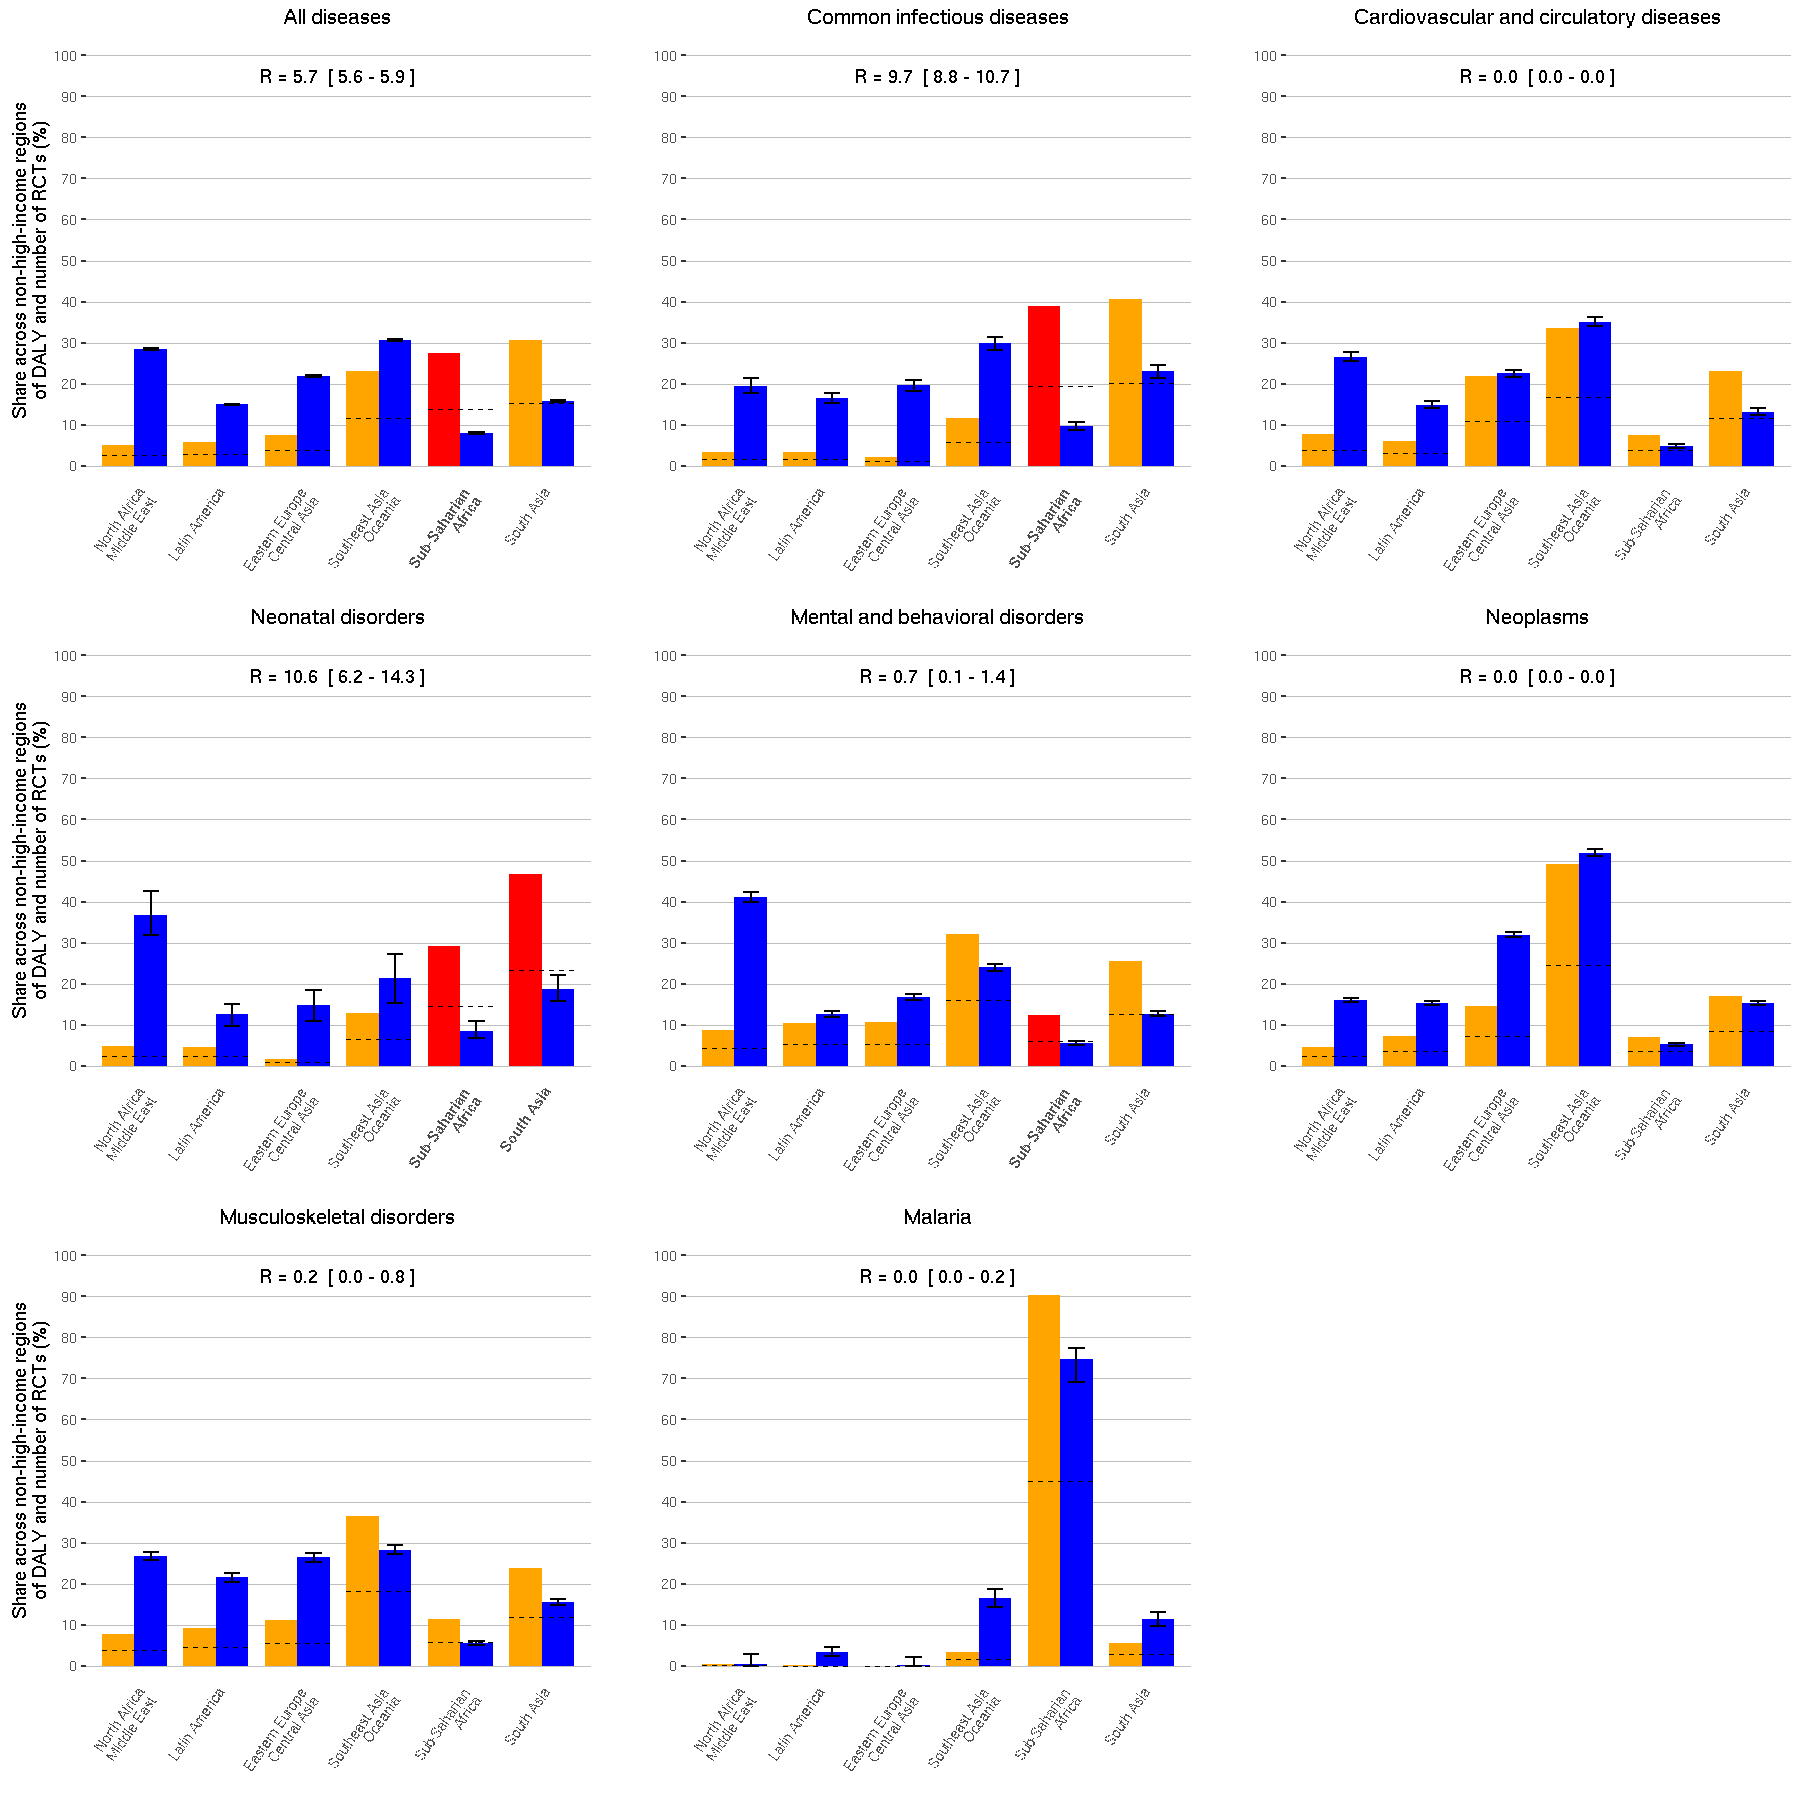

In [24]:
options(repr.plot.width=15, repr.plot.height=15)

grid.arrange(L[[1]],L[[2]],L[[3]],L[[4]],L[[5]],L[[6]],L[[7]],L[[8]], ncol=3)

In [25]:
ggsave(filename = "../Figures/RCTs_vs_DALYs_withindis_NonHI.pdf",
       plot=grid.arrange(L[[1]],L[[2]],L[[3]],L[[4]],L[[5]],L[[6]],L[[7]],L[[8]], ncol=3),
       width=15,height=15)